In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [3]:
df = pd.read_csv("Pairwise Cluster Comparisons - FINAL.txt", sep="\t")

In [4]:
def is_same_range(seq1, seq2, start, end):
    if pd.isnull(seq1) or pd.isnull(seq2):
        return False
    return seq1[start:end] == seq2[start:end]

In [5]:
results = []

for fam_col in [col for col in df.columns if col.startswith("Family_")]:
    fam_df = df[df[fam_col] == "Yes"].copy()
    fam_label = fam_col.replace("Family_", "HRC")

    if fam_df.empty:
        continue

    # Count pairs where bases 13–16 (index 12–16) match
    count_13_16 = sum(
        is_same_range(s1, s2, 12, 16)
        for s1, s2 in zip(fam_df["Sequence_miRNA1"], fam_df["Sequence_miRNA2"])
    )

    # Count pairs where bases 18–21 (index 17–21) match
    count_18_21 = sum(
        is_same_range(s1, s2, 17, 21)
        for s1, s2 in zip(fam_df["Sequence_miRNA1"], fam_df["Sequence_miRNA2"])
    )

    results.append({
        "Homology Class Region": fam_label,
        "13–16 Homologous": count_13_16,
        "18–21 Homologous": count_18_21
    })

In [6]:
summary_df = pd.DataFrame(results)
display(summary_df)

,Homology Class Region,13–16 Homologous,18–21 Homologous
0,HRC1_8,271,212
1,HRC2_8,298,250
2,HRC1_7,304,244
3,HRC2_7,346,293
4,HRC3_8,333,272
5,HRC1_6,359,279


In [10]:
def pval_to_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

In [13]:
records = []

for fam_col in [col for col in df.columns if col.startswith("Family_")]:
    fam_df = df[df[fam_col] == "Yes"].copy()
    fam_label = fam_col.replace("Family_", "HRC")
    if fam_df.empty:
        continue

    for _, row in fam_df.iterrows():
        s1, s2 = row["Sequence_miRNA1"], row["Sequence_miRNA2"]
        if pd.isnull(s1) or pd.isnull(s2):
            continue

        base_group = "Seed only"
        if s1[12:16] == s2[12:16]:
            base_group = "Seed + 13-16"
        if s1[17:21] == s2[17:21]:
            base_group = "Seed + 18-21"

        records.append({
            "Family": fam_label,
            "Jaccard": row["Jaccard"],
            "Group": base_group
        })

melted = pd.DataFrame(records)

In [14]:
melted = melted[melted["Group"].isin(["Seed + 13-16", "Seed + 18-21"])]

Save plot as PNG? (yes/no):  yes


Plot saved as jaccard_violinplot_seed_13vs18.png


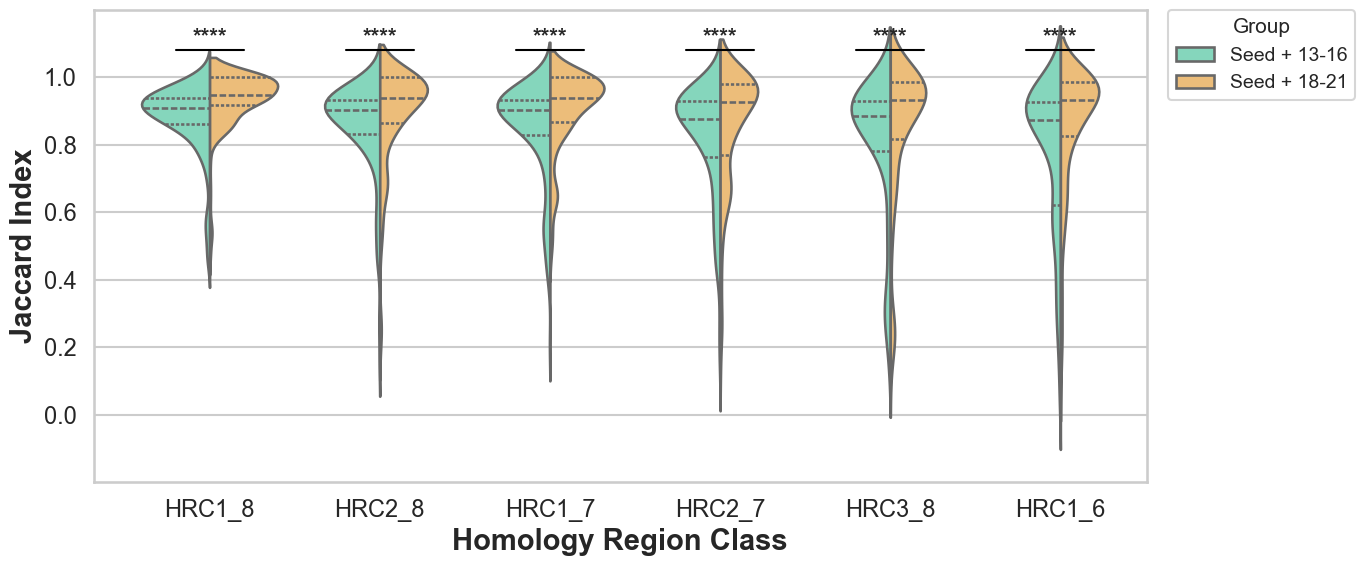

In [15]:
sns.set(style="whitegrid", context="talk")
palette_dict = {
    "Seed + 13-16": "#78e3c1",  
    "Seed + 18-21": "#ffc067"   
}

plt.figure(figsize=(14, 6))
ax = sns.violinplot(
    data=melted,
    x="Family",
    y="Jaccard",
    hue="Group",
    split=True,
    inner="quartile",
    palette=palette_dict,
)

families = sorted(melted["Family"].unique())
test_results = []

for i, fam in enumerate(families):
    sub_df = melted[melted["Family"] == fam]
    g1 = sub_df[sub_df["Group"] == "Seed + 13-16"]["Jaccard"]
    g2 = sub_df[sub_df["Group"] == "Seed + 18-21"]["Jaccard"]

    if len(g1) == 0 or len(g2) == 0:
        continue

    stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")
    stars = pval_to_stars(p_value)

    test_results.append({
        "Family": fam,
        "n Seed + 13-16": len(g1),
        "n Seed + 18-21": len(g2),
        "Median 13-16": g1.median(),
        "Median 18-21": g2.median(),
        "p-value": p_value,
        "Significance": stars
    })

    y_max = melted["Jaccard"].max() + 0.08
    x1, x2 = i - 0.2, i + 0.2
    plt.plot([x1, x2], [y_max, y_max], color='black', linewidth=1.5)
    plt.text((x1 + x2) / 2, y_max + 0.01, stars, ha='center', va='bottom', fontsize=16, fontweight="bold")

plt.ylabel("Jaccard Index", fontsize=21, fontweight="bold")
plt.xlabel("Homology Region Class", fontsize=21, fontweight="bold")
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylim(-0.2, 1.2)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend(title="Group", title_fontsize=15, fontsize=14, loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("jaccard_violinplot_seed_13vs18.png", dpi=300, bbox_inches='tight')
    print("Plot saved as jaccard_violinplot_seed_13vs18.png")

plt.show()